### Task 1 and 2 (Komal pawar)


In [144]:
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [145]:
DATA_DIR = (r"C:\Users\LaptopCheckout\Downloads\unme\UTKFace")
TRAIN_TEST_SPLIT = 0.7#splotting the data with 70%
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())
ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [146]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [147]:
f1 = glob.glob(os.path.join(DATA_DIR, "*.jpg"))


In [148]:
attributes = list(map(parse_filepath, f1))

C:\Users\LaptopCheckout\Downloads\unme\UTKFace\39_1_20170116174525125.jpg.chip.jpg
C:\Users\LaptopCheckout\Downloads\unme\UTKFace\61_1_20170109142408075.jpg.chip.jpg
C:\Users\LaptopCheckout\Downloads\unme\UTKFace\61_1_20170109150557335.jpg.chip.jpg


In [149]:
df1 = pd.DataFrame(attributes)
df1['file'] = f1
df1.columns = ['age', 'gender', 'race', 'file']
df1 = df1.dropna()
df1.head()

,age,gender,race,file
0,100.0,male,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...
1,100.0,male,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...
2,100.0,female,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...
3,100.0,female,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...
4,100.0,female,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...


In [150]:
df1 = df1[(df1['age'] > 10) & (df1['age'] < 65)]
df1['gender'].unique()

array(['male', 'female'], dtype=object)

In [151]:
p = np.random.permutation(len(df1))
train_up_to = int(len(df1) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
df1['gender_id'] = df1['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df1['race_id'] = df1['race'].map(lambda race: RACE_ID_MAP[race])
max_age = df1['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [152]:
df1

,age,gender,race,file,gender_id,race_id
188,11.0,male,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,0,0
189,11.0,male,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,0,0
190,11.0,male,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,0,0
191,11.0,male,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,0,0
192,11.0,male,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,0,0
...,...,...,...,...,...,...
21078,64.0,female,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,1,0
21079,64.0,female,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,1,0
21080,64.0,female,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,1,0
21081,64.0,female,white,C:\Users\LaptopCheckout\Downloads\unme\UTKFace...,1,0


In [153]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
def get_data_generator(df1, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df1.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, len(GENDER_ID_MAP)))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [154]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _
input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)
model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop',loss={'age_output': 'mse','race_output':'categorical_crossentropy','gender_output':'categorical_crossentropy'},loss_weights={'age_output': 2.,'race_output': 1.5,'gender_output':1},metrics={'age_output': 'mae','race_output': 'accuracy','gender_output':'accuracy'})
#model.summary()

In [155]:
#model.summary()

In [156]:
from tensorflow.keras.callbacks import ModelCheckpoint
batch_size = 16
valid_batch_size = 16
train_gen = get_data_generator(df1, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df1, valid_idx, for_training=True, batch_size=valid_batch_size)
callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]
history = model.fit_generator(train_gen,steps_per_epoch=len(train_idx)//batch_size,epochs=2,callbacks=callbacks,validation_data=valid_gen,validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/2
567/567 [==============================] - 1285s 2s/step - loss: 2.5569 - age_output_loss: 0.0482 - race_output_loss: 1.2671 - gender_output_loss: 0.5598 - age_output_mae: 0.1733 - race_output_accuracy: 0.5245 - gender_output_accuracy: 0.7396 - val_loss: 3.0422 - val_age_output_loss: 0.0476 - val_race_output_loss: 1.4943 - val_gender_output_loss: 0.7055 - val_age_output_mae: 0.1714 - val_race_output_accuracy: 0.4493 - val_gender_output_accuracy: 0.5183
Epoch 2/2
567/567 [==============================] - 1238s 2s/step - loss: 1.7218 - age_output_loss: 0.0304 - race_output_loss: 0.8905 - gender_output_loss: 0.3253 - age_output_mae: 0.1382 - race_output_accuracy: 0.6749 - gender_output_accuracy: 0.8646 - val_loss: 2.1338 - val_age_output_loss: 0.0363 - val_race_output_loss: 1.0477 - val_gender_output_loss: 0.4897 - val_age_output_mae: 0.1587 - val_race_output_accuracy: 0.6211 - val_gender_output_accuracy: 0.7765


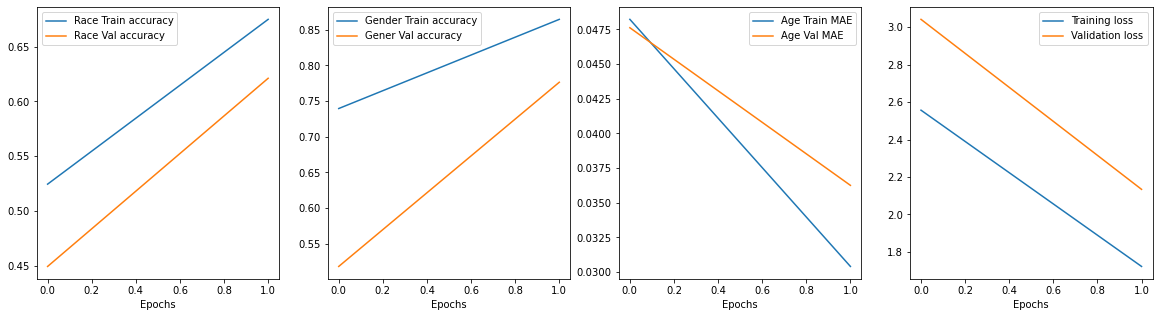

In [157]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
 
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy') 
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend() 
    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()
plot_train_history(history)


In [160]:
test_gen = get_data_generator(df1, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx))))

{'loss': 2.119696617126465,
 'age_output_loss': 0.0350666269659996,
 'race_output_loss': 1.0483360290527344,
 'gender_output_loss': 0.4770592153072357,
 'age_output_mae': 0.15584135055541992,
 'race_output_accuracy': 0.6057412624359131,
 'gender_output_accuracy': 0.784338653087616}

In [161]:
test_gen = get_data_generator(df1, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)


In [162]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age


In [163]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))
print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))


Classification report for race
              precision    recall  f1-score   support

           0       0.73      0.83      0.77        64
           1       0.59      0.74      0.65        23
           2       0.69      0.75      0.72        12
           3       0.57      0.21      0.31        19
           4       0.17      0.10      0.12        10

    accuracy                           0.66       128
   macro avg       0.55      0.53      0.52       128
weighted avg       0.63      0.66      0.63       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        71
           1       0.94      0.58      0.72        57

    accuracy                           0.80       128
   macro avg       0.84      0.78      0.78       128
weighted avg       0.83      0.80      0.79       128



In [167]:
import math
n = 30
random_indices = np.random.permutation(n)
a = 10
b = 20
c = 10
for i, img_idx in enumerate(random_indices):
    pred_hash = a * int(age_pred[img_idx]) + b * gender_pred[img_idx] + c * race_pred[img_idx]
    act_hash = a * int(age_true[img_idx]) + b * gender_true[img_idx] + c * race_true[img_idx]
    print("Actual", pred_hash)
    print("Prediction", act_hash)


Actual 430
Prediction 570
Actual 340
Prediction 380
Actual 420
Prediction 410
Actual 360
Prediction 610
Actual 440
Prediction 280
Actual 400
Prediction 300
Actual 370
Prediction 160
Actual 390
Prediction 260
Actual 370
Prediction 280
Actual 370
Prediction 480
Actual 420
Prediction 370
Actual 440
Prediction 560
Actual 430
Prediction 570
Actual 350
Prediction 350
Actual 440
Prediction 480
Actual 360
Prediction 320
Actual 390
Prediction 470
Actual 350
Prediction 270
Actual 410
Prediction 190
Actual 410
Prediction 520
Actual 310
Prediction 380
Actual 360
Prediction 420
Actual 410
Prediction 270
Actual 480
Prediction 380
Actual 400
Prediction 370
Actual 370
Prediction 180
Actual 450
Prediction 580
Actual 370
Prediction 490
Actual 380
Prediction 170
Actual 380
Prediction 300
